In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec 18 09:03:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [40]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! mkdir datasets
! cp "/content/drive/My Drive/Kaggle/fake-image-classification-challenge/data.zip" "/content/datasets"

In [5]:
! unzip 'datasets/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: data/train/real/05803.jpg  
  inflating: data/train/real/05804.jpg  
  inflating: data/train/real/05805.jpg  
  inflating: data/train/real/05806.jpg  
  inflating: data/train/real/05807.jpg  
  inflating: data/train/real/05808.jpg  
  inflating: data/train/real/05809.jpg  
  inflating: data/train/real/05810.jpg  
  inflating: data/train/real/05811.jpg  
  inflating: data/train/real/05812.jpg  
  inflating: data/train/real/05813.jpg  
  inflating: data/train/real/05814.jpg  
  inflating: data/train/real/05815.jpg  
  inflating: data/train/real/05816.jpg  
  inflating: data/train/real/05817.jpg  
  inflating: data/train/real/05818.jpg  
  inflating: data/train/real/05819.jpg  
  inflating: data/train/real/05820.jpg  
  inflating: data/train/real/05821.jpg  
  inflating: data/train/real/05822.jpg  
  inflating: data/train/real/05823.jpg  
  inflating: data/train/real/05824.jpg  
  inflating: data/train/real/05825.jpg  
  infl

In [41]:
base_path = 'data/'
train_image_gen = ImageDataGenerator(rescale=1./255., rotation_range=30, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, fill_mode="nearest")
valid_data_gen = ImageDataGenerator(rescale=1./255)
batch_size = 32

train_flow = train_image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

valid_flow = valid_data_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 14400 images belonging to 2 classes.
Found 3600 images belonging to 2 classes.


In [42]:
vgg_model = VGG16(weights=None, include_top=False, input_shape = (224,224,3))

last_layer = vgg_model.get_layer('block5_pool').output
flat_layer = Flatten(name='flatten')(last_layer)
fc1 = Dense(4096, activation='relu', name='fc1')(flat_layer)
dropout1 = Dropout(0.5, name='dropout1')(fc1)
fc2 = Dense(4096, activation='relu', name='fc2')(dropout1)
dropout2 = Dropout(0.5, name='dropout2')(fc2)
dense = Dense(1, activation='sigmoid', name='dense')(dropout2)

model = Model(vgg_model.input, dense)

In [43]:
model.compile(
    optimizer=Adam(learning_rate=0.00001), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [44]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [45]:
filepath = "/content/drive/My Drive/Kaggle/fake-image-classification-challenge/checkpoints/vgg16-checkpoint-loss.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch')

In [46]:
train_steps = 14400//batch_size
valid_steps = 3600//batch_size

In [ ]:
history = model.fit(
    train_flow,
    epochs=50,
    steps_per_epoch=train_steps,
    validation_data=valid_flow,
    validation_steps=valid_steps,
    callbacks=[checkpoint]
)

Epoch 1/50
450/450 [==============================] - 221s 462ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5003
Epoch 2/50
450/450 [==============================] - 205s 456ms/step - loss: 0.6930 - accuracy: 0.5120 - val_loss: 0.6929 - val_accuracy: 0.5006
Epoch 3/50
450/450 [==============================] - 196s 435ms/step - loss: 0.6827 - accuracy: 0.5498 - val_loss: 0.6589 - val_accuracy: 0.5862
Epoch 4/50
450/450 [==============================] - 202s 448ms/step - loss: 0.6717 - accuracy: 0.5791 - val_loss: 0.6473 - val_accuracy: 0.6035
Epoch 5/50
450/450 [==============================] - 200s 444ms/step - loss: 0.6610 - accuracy: 0.5909 - val_loss: 0.6332 - val_accuracy: 0.6306
Epoch 6/50
450/450 [==============================] - 164s 364ms/step - loss: 0.6533 - accuracy: 0.6048 - val_loss: 0.6344 - val_accuracy: 0.6270
Epoch 7/50
450/450 [==============================] - 194s 430ms/step - loss: 0.6468 - accuracy: 0.6152 - val_loss: 0.6178 -

In [ ]:
model.save('vgg16-small-epochs=50', save_format='tf')
! cp -r "vgg16-small-epochs=50" "/content/drive/My Drive/Kaggle/fake-image-classification-challenge/trained-models"

INFO:tensorflow:Assets written to: vgg16-small-epochs=50/assets


In [48]:
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [49]:
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

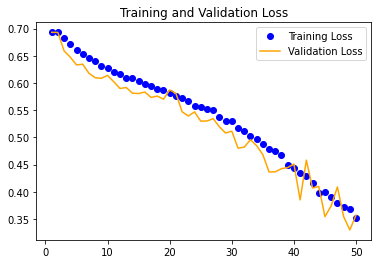

In [ ]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)

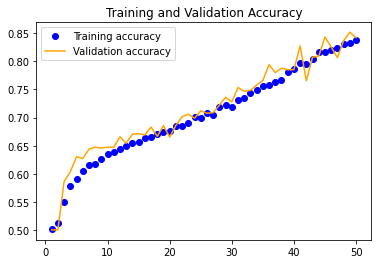

In [ ]:
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [ ]:
history2 = model.fit(
    train_flow,
    epochs=100,
    initial_epoch=50,
    steps_per_epoch=train_steps,
    validation_data=valid_flow,
    validation_steps=valid_steps,
    callbacks=[checkpoint]
)

Epoch 51/100
450/450 [==============================] - 228s 477ms/step - loss: 0.3436 - accuracy: 0.8445 - val_loss: 0.3061 - val_accuracy: 0.8577
Epoch 52/100
450/450 [==============================] - 206s 457ms/step - loss: 0.3388 - accuracy: 0.8497 - val_loss: 0.3245 - val_accuracy: 0.8535
Epoch 53/100
450/450 [==============================] - 198s 440ms/step - loss: 0.3316 - accuracy: 0.8529 - val_loss: 0.3239 - val_accuracy: 0.8516
Epoch 54/100
450/450 [==============================] - 198s 440ms/step - loss: 0.3254 - accuracy: 0.8549 - val_loss: 0.3354 - val_accuracy: 0.8426
Epoch 55/100
450/450 [==============================] - 198s 440ms/step - loss: 0.3312 - accuracy: 0.8495 - val_loss: 0.3069 - val_accuracy: 0.8624
Epoch 56/100
450/450 [==============================] - 197s 438ms/step - loss: 0.3146 - accuracy: 0.8576 - val_loss: 0.3066 - val_accuracy: 0.8636
Epoch 57/100
450/450 [==============================] - 212s 470ms/step - loss: 0.3026 - accuracy: 0.8685 - val_

In [ ]:
model.save('vgg16-small-epochs=100', save_format='tf')
! cp -r "vgg16-small-epochs=100" "/content/drive/My Drive/Kaggle/fake-image-classification-challenge/trained-models"

INFO:tensorflow:Assets written to: vgg16-small-epochs=100/assets


In [ ]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

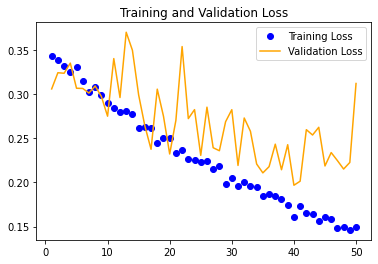

In [ ]:
plot_loss(range(1, len(loss2) + 1), loss2, val_loss2)

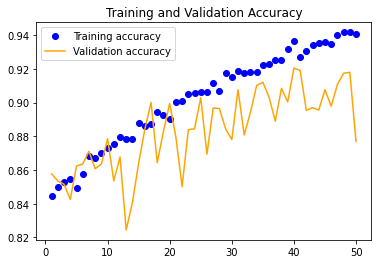

In [ ]:
plot_accuracy(range(1, len(loss2) + 1), acc2, val_acc2)

In [ ]:
history3 = model.fit(
    train_flow,
    epochs=125,
    initial_epoch=100,
    steps_per_epoch=train_steps,
    validation_data=valid_flow,
    validation_steps=valid_steps,
    callbacks=[checkpoint]
)

Epoch 101/125
450/450 [==============================] - 202s 450ms/step - loss: 0.1439 - accuracy: 0.9423 - val_loss: 0.2322 - val_accuracy: 0.9051
Epoch 102/125
450/450 [==============================] - 207s 459ms/step - loss: 0.1427 - accuracy: 0.9438 - val_loss: 0.2080 - val_accuracy: 0.9191
Epoch 103/125
450/450 [==============================] - 199s 441ms/step - loss: 0.1464 - accuracy: 0.9409 - val_loss: 0.1977 - val_accuracy: 0.9171
Epoch 104/125
450/450 [==============================] - 199s 443ms/step - loss: 0.1315 - accuracy: 0.9471 - val_loss: 0.2249 - val_accuracy: 0.9088
Epoch 105/125
450/450 [==============================] - 199s 443ms/step - loss: 0.1330 - accuracy: 0.9451 - val_loss: 0.2202 - val_accuracy: 0.9143
Epoch 106/125
450/450 [==============================] - 199s 442ms/step - loss: 0.1329 - accuracy: 0.9468 - val_loss: 0.3477 - val_accuracy: 0.8697
Epoch 107/125
450/450 [==============================] - 199s 442ms/step - loss: 0.1325 - accuracy: 0.9489

In [ ]:
model.save('vgg16-small-epochs=125', save_format='tf')
! cp -r "vgg16-small-epochs=125" "/content/drive/My Drive/Kaggle/fake-image-classification-challenge/trained-models"

INFO:tensorflow:Assets written to: vgg16-small-epochs=125/assets


In [ ]:
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

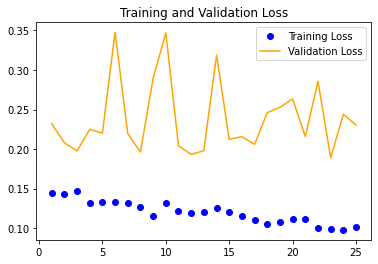

In [ ]:
plot_loss(range(1, len(loss3) + 1), loss3, val_loss3)

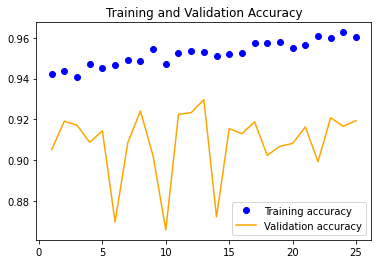

In [ ]:
plot_accuracy(range(1, len(loss3) + 1), acc3, val_acc3)

In [50]:
base_path = 'data/'
train_image_gen = ImageDataGenerator(rescale=1./255., rotation_range=30, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, fill_mode="nearest")
valid_data_gen = ImageDataGenerator(rescale=1./255)
batch_size = 32

train_flow = train_image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

valid_flow = valid_data_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 14400 images belonging to 2 classes.
Found 3600 images belonging to 2 classes.


In [52]:
base_model = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights=None)
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x, name='inception_v3')

In [53]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [54]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 149, 149, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 149, 149, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                      

In [55]:
filepath = "/content/drive/My Drive/Kaggle/fake-image-classification-challenge/checkpoints/inceptionv3-checkpoint-loss.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch')

In [56]:
train_steps = 14400//batch_size
valid_steps = 3600//batch_size

In [ ]:
history = model.fit(
    train_flow,
    epochs=50,
    steps_per_epoch=train_steps,
    validation_data=valid_flow,
    validation_steps=valid_steps,
    callbacks=[checkpoint]
)

Epoch 1/50
450/450 [==============================] - 338s 699ms/step - loss: 1.0638 - accuracy: 0.5551 - val_loss: 0.6805 - val_accuracy: 0.5737
Epoch 2/50
450/450 [==============================] - 335s 744ms/step - loss: 0.6587 - accuracy: 0.6150 - val_loss: 0.6219 - val_accuracy: 0.6568
Epoch 3/50
450/450 [==============================] - 306s 680ms/step - loss: 0.6394 - accuracy: 0.6382 - val_loss: 0.7584 - val_accuracy: 0.6529
Epoch 4/50
450/450 [==============================] - 301s 669ms/step - loss: 0.6070 - accuracy: 0.6650 - val_loss: 0.8781 - val_accuracy: 0.6417
Epoch 5/50
450/450 [==============================] - 301s 668ms/step - loss: 0.5733 - accuracy: 0.6914 - val_loss: 1.8508 - val_accuracy: 0.6275
Epoch 6/50
450/450 [==============================] - 308s 685ms/step - loss: 0.5435 - accuracy: 0.7199 - val_loss: 0.8133 - val_accuracy: 0.7132
Epoch 7/50
450/450 [==============================] - 303s 674ms/step - loss: 0.5032 - accuracy: 0.7459 - val_loss: 1.4251 -

In [ ]:
model.save('inceptionv3-small-epochs=50', save_format='tf')
! cp -r "inceptionv3-small-epochs=50" "/content/drive/My Drive/Kaggle/fake-image-classification-challenge/trained-models"

INFO:tensorflow:Assets written to: inceptionv3-small-epochs=50/assets


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

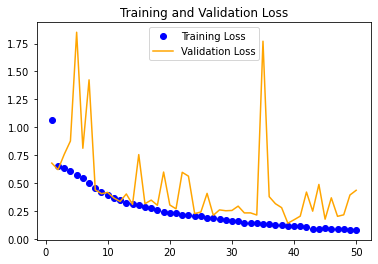

In [ ]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)

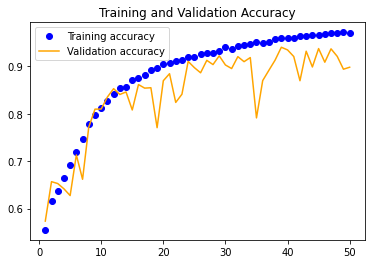

In [ ]:
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [ ]:
history2 = model.fit(
    train_flow,
    epochs=75,
    initial_epoch=50,
    steps_per_epoch=train_steps,
    validation_data=valid_flow,
    validation_steps=valid_steps,
    callbacks=[checkpoint]
)

Epoch 51/75
450/450 [==============================] - 374s 778ms/step - loss: 0.0806 - accuracy: 0.9737 - val_loss: 0.1005 - val_accuracy: 0.9590
Epoch 52/75
450/450 [==============================] - 334s 732ms/step - loss: 0.0796 - accuracy: 0.9737 - val_loss: 0.2172 - val_accuracy: 0.9369
Epoch 53/75
450/450 [==============================] - 311s 691ms/step - loss: 0.0837 - accuracy: 0.9715 - val_loss: 0.3569 - val_accuracy: 0.8990
Epoch 54/75
450/450 [==============================] - 309s 686ms/step - loss: 0.0750 - accuracy: 0.9767 - val_loss: 0.3262 - val_accuracy: 0.9233
Epoch 55/75
450/450 [==============================] - 304s 676ms/step - loss: 0.0753 - accuracy: 0.9750 - val_loss: 0.2203 - val_accuracy: 0.9528
Epoch 56/75
450/450 [==============================] - 307s 682ms/step - loss: 0.0704 - accuracy: 0.9808 - val_loss: 0.1715 - val_accuracy: 0.9487
Epoch 57/75
450/450 [==============================] - 309s 686ms/step - loss: 0.0709 - accuracy: 0.9764 - val_loss: 0

In [ ]:
model.save('inceptionv3-small-epochs=75', save_format='tf')
! cp -r "inceptionv3-small-epochs=75" "/content/drive/My Drive/Kaggle/fake-image-classification-challenge/trained-models"

INFO:tensorflow:Assets written to: inceptionv3-small-epochs=75/assets


In [ ]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

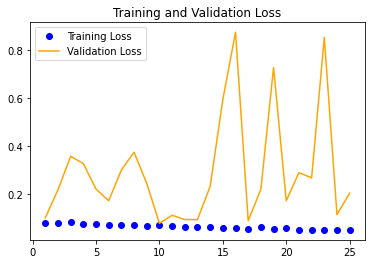

In [ ]:
plot_loss(range(1, len(loss2) + 1), loss2, val_loss2)

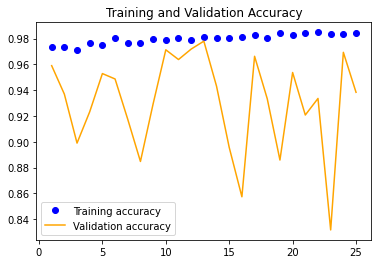

In [ ]:
plot_accuracy(range(1, len(loss2) + 1), acc2, val_acc2)

In [57]:
! mkdir models

# fetching the saved model from gdrive
! cp -r "/content/drive/MyDrive/Kaggle/fake-image-classification-challenge/checkpoints/inceptionv3-checkpoint-loss-0.0773-0.9713.h5" "/content/models/"
! cp -r "/content/drive/MyDrive/Kaggle/fake-image-classification-challenge/checkpoints/vgg16-checkpoint-loss-0.1963-0.9241.h5" "/content/models/"

# loading the saved model
loaded_model_1 = tf.keras.models.load_model('/content/models/inceptionv3-checkpoint-loss-0.0773-0.9713.h5')
loaded_model_2 = tf.keras.models.load_model('/content/models/vgg16-checkpoint-loss-0.1963-0.9241.h5')

In [58]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

In [59]:
valid_flow_1 = valid_data_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(299, 299),
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
)

Found 3600 images belonging to 2 classes.


In [60]:
y_pred_1 = loaded_model_1.predict(valid_flow_1)
y_test = valid_flow_1.classes
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_1))
print("AP Score:", metrics.average_precision_score(y_test, y_pred_1))
print(metrics.classification_report(y_test, y_pred_1 >= 0.5))

ROC AUC Score: 0.996812037037037
AP Score: 0.9964968046310925
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1800
           1       0.96      0.98      0.97      1800

    accuracy                           0.97      3600
   macro avg       0.97      0.97      0.97      3600
weighted avg       0.97      0.97      0.97      3600



In [62]:
valid_flow_2 = valid_data_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
)

Found 3600 images belonging to 2 classes.


In [63]:
y_pred_2 = loaded_model_2.predict(valid_flow_2)
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_2))
print("AP Score:", metrics.average_precision_score(y_test, y_pred_2))
print(metrics.classification_report(y_test, y_pred_2 >= 0.5))

ROC AUC Score: 0.9790722222222222
AP Score: 0.9797534528513392
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1800
           1       0.93      0.91      0.92      1800

    accuracy                           0.92      3600
   macro avg       0.92      0.92      0.92      3600
weighted avg       0.92      0.92      0.92      3600



In [64]:
y_pred = (y_pred_1 + y_pred_2) / 2
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred >= 0.5))

ROC AUC Score: 0.9971530864197531
AP Score: 0.9972394270053284
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1800
           1       0.98      0.98      0.98      1800

    accuracy                           0.98      3600
   macro avg       0.98      0.98      0.98      3600
weighted avg       0.98      0.98      0.98      3600



In [65]:
test_data_gen = ImageDataGenerator(rescale=1./255)

In [66]:
test_flow_1 = test_data_gen.flow_from_directory(
    base_path,
    classes=['test'],
    class_mode=None,
    shuffle=False,
    target_size=(299, 299)
)

Found 13500 images belonging to 1 classes.


In [67]:
test_flow_2 = test_data_gen.flow_from_directory(
    base_path,
    classes=['test'],
    class_mode=None,
    shuffle=False,
    target_size=(224, 224)
)

Found 13500 images belonging to 1 classes.


In [68]:
preds_1 = loaded_model_1.predict(test_flow_1)
preds_2 = loaded_model_2.predict(test_flow_2)
preds = (preds_1 + preds_2) / 2
predicted_class = np.where(preds >= 0.5, "real", "fake")
test_data=pd.read_csv(base_path + "test.csv")
test_data['label'] = predicted_class
test_data.to_csv("Data Alchemists.csv", index=False)